In [63]:
'''
  Variational Autoencoder (VAE) with the Keras Functional API.
'''

import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import fashion_mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [64]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = fashion_mnist.load_data()

In [65]:
# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 200
no_epochs = 50
validation_split = 0.2
verbosity = 1
latent_dim = 32
num_channels = 1

In [66]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [67]:
# # =================
# # Encoder
# # =================

# Definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

In [68]:
# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)
print(conv_shape)

(None, 7, 7, 16)


In [69]:
# Define sampling with reparameterization trick
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

In [70]:
# Use reparameterization trick to ensure correct gradient
z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

In [71]:
# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 8)    80          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 14, 14, 8)    32          conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 7, 7, 16)     1168        batch_normalization_22[0][0]     
____________________________________________________________________________________________

In [72]:
# =================
# Decoder
# =================

# Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

In [73]:
# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 784)               25872     
_________________________________________________________________
batch_normalization_25 (Batc (None, 784)               3136      
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 16)        2320      
_________________________________________________________________
batch_normalization_26 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 8)         1160

In [74]:
# =================
# VAE as a whole
# =================

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 32), (None, 32),  18468     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         32657     
Total params: 51,125
Trainable params: 49,421
Non-trainable params: 1,704
_________________________________________________________________


In [ ]:
# set loss 
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [60]:
# Define loss
def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
  # KL divergence loss
  kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  # Total loss = 50% rec + 50% KL divergence loss
  return K.mean(reconstruction_loss + kl_loss)

In [75]:
# Compile VAE
vae.compile(optimizer='sgd', loss=kl_reconstruction_loss)

# Train autoencoder
vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 21s 431us/step - loss: 3424.8876 - val_loss: 3485.4847
Epoch 2/50
48000/48000 [==============================] - 20s 411us/step - loss: 3452.6871 - val_loss: 3485.3539
Epoch 3/50
48000/48000 [==============================] - 18s 379us/step - loss: 3452.6482 - val_loss: 3485.3301
Epoch 4/50
48000/48000 [==============================] - 18s 379us/step - loss: 3452.6328 - val_loss: 3485.3173
Epoch 5/50
48000/48000 [==============================] - 18s 379us/step - loss: 3452.6244 - val_loss: 3485.3099
Epoch 6/50
48000/48000 [==============================] - 18s 378us/step - loss: 3452.6193 - val_loss: 3485.3054
Epoch 7/50
48000/48000 [==============================] - 18s 379us/step - loss: 3452.6155 - val_loss: 3485.3019
Epoch 8/50
48000/48000 [==============================] - 18s 383us/step - loss: 3452.6129 - val_loss: 3485.2996
Epoch 9/50
48000/48000 [======================

In [77]:
# =============================================
# Take a sample for visualization purposes
# =============================================
input_sample = input_test[:1]
reconstruction = vae.predict([input_sample])

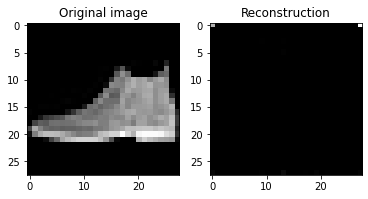

In [78]:
# =============================================
# Visualize input-->reconstruction
# =============================================
fig, axes = plt.subplots(1, 2)
plt.gray
fig.set_size_inches(6, 3.5)
input_sample_reshaped = input_sample.reshape((28, 28))
reconsstruction_reshaped = reconstruction.reshape((28, 28))
axes[0].imshow(input_sample_reshaped) 
axes[0].set_title('Original image')
axes[1].imshow(reconsstruction_reshaped)
axes[1].set_title('Reconstruction')
plt.show()

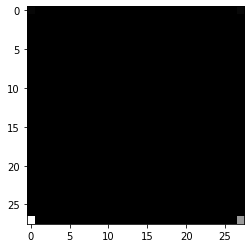

In [45]:
plt.figure()
plt.gray()
plt.imshow(reconsstruction_reshaped)

In [79]:
latent = np.random.rand(32)*(max - min) + min
decoded_img = decoder.predict(np.array([latent]))
decoded_img = decoded_img[0].reshape(28, 28)
print(decoded_img.shape)

TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'builtin_function_or_method'